## Consolidação dos experimentos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np

In [2]:
ROOT_DIR = os.path.abspath('.')
MODELS_DIR = os.path.join(ROOT_DIR, 'models')
CUSTOM_MODEL = os.path.join(MODELS_DIR, 'experiments', 'dynamic_range_quantization.tflite')
# IMAGE_DIR =  os.path.join(ROOT_DIR, 'custom_dataset')
IMAGE_DIR =  os.path.join(ROOT_DIR, 'test')


### Carregar arquivos

In [3]:
df_py = pd.read_csv(os.path.join(ROOT_DIR, 'experiments.csv'))
df_py['language'] = 'py'
df_py.head()

,file,modelo,time,score,model_size,language
0,KJD-0885.jpg,original,0.232882,0.792455,11497428,py
1,LBS-2737.jpg,original,0.209675,0.830200,11497428,py
2,IMG_0387.jpg,original,0.211087,0.831097,11497428,py
3,CYU-8900.jpg,original,0.210316,0.799787,11497428,py
4,JID-9361.jpg,original,0.209647,0.799481,11497428,py


In [4]:
df_cc = pd.read_csv(os.path.join(ROOT_DIR, 'experiments_cc.csv'))
df_cc = df_cc.loc[df_cc['modelo'] != 'full_int8']
df_cc['language'] = 'cc'
df_cc['time'] = df_cc['time']/1000
df_cc.head()

,file,modelo,time,score,language
0,Cars424.png,original,0.239,0.557576,cc
1,KJD-0885.jpg,original,0.215,0.815457,cc
2,Cars426.png,original,0.214,0.724777,cc
3,Cars414.png,original,0.225,0.078145,cc
4,Cars427.png,original,0.212,0.068553,cc


Tipos de modelos quantizados

In [5]:
print(df_py['modelo'].unique())
print(df_cc['modelo'].unique())

['original' 'full_int8' 'dynamic' 'int8' 'float16']
['original' 'dynamic' 'int8' 'float16']


### Tamanho dos modelos quantizados

In [6]:
import glob
ROOT_DIR = os.path.abspath('.')
MODELS_DIR = os.path.join(ROOT_DIR, 'models')
models = glob.glob(os.path.join(MODELS_DIR, 'experiments', '*.tflite'))

In [7]:
import os

size_model = {}

for model in models:
    name = model.split('/')[-1].split('.')[0]
    size_model[name] = round(os.path.getsize(model)/1000000, 2)

size_model

{'float16': 5.83,
 'int8': 3.74,
 'original': 11.5,
 'full_int8': 3.74,
 'dynamic': 3.18}

In [ ]:
df_py['size'] = df_py['modelo'].map(size_model)
df_py['perc_size'] = round(df_py['size'] / df_py['size'].max(),3) * 100


df_cc['size'] = df_cc['modelo'].map(size_model)
df_cc['perc_size'] = round(df_cc['size'] / df_cc['size'].max(),3) * 100

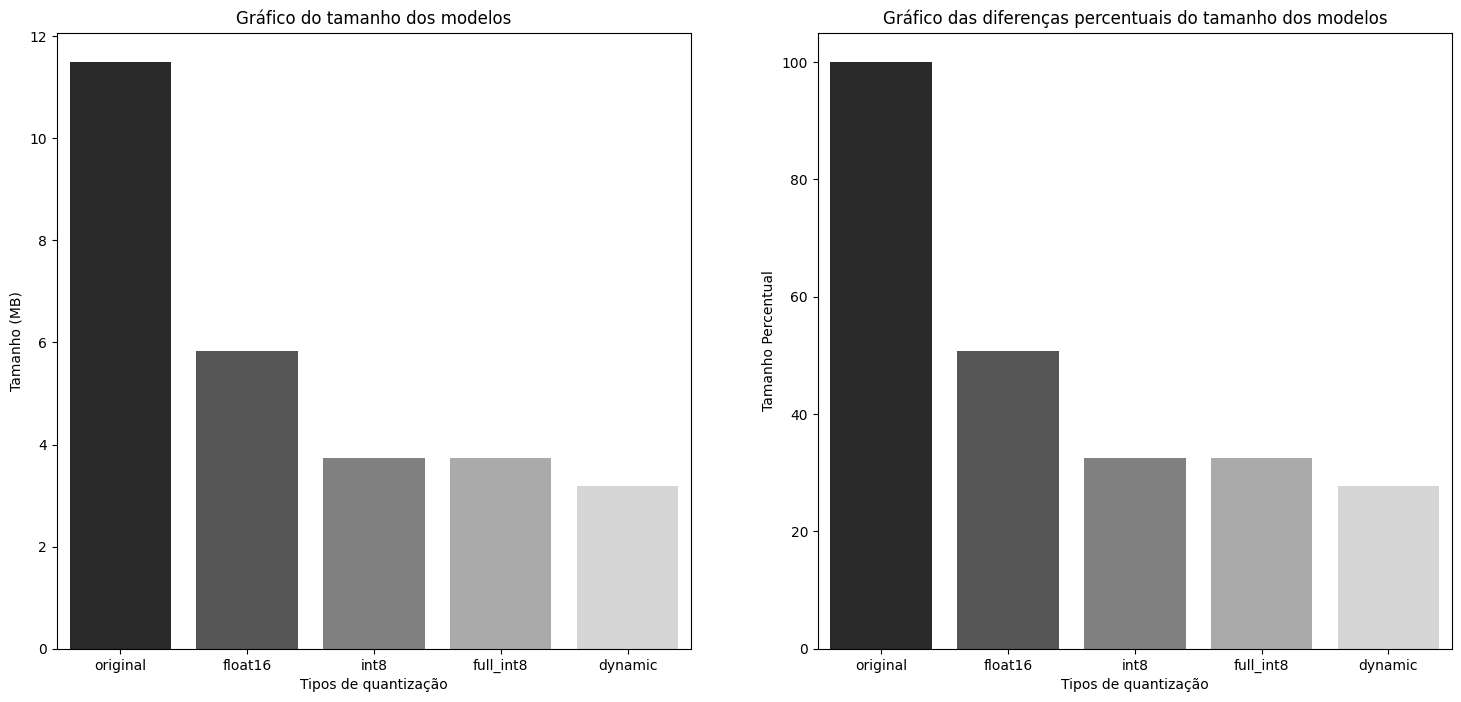

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

g1 = sns.barplot(data=df_cc.sort_values(by=['size'], ascending=False), x='modelo', y='size', palette='binary_r', ax=ax[0])
g1.set_xlabel('Tipos de quantização')
g1.set_ylabel('Tamanho (MB)')
g1.set_title('Gráfico do tamanho dos modelos')

# Plot 2
g2 = sns.barplot(data=df_cc.sort_values(by=['perc_size'], ascending=False), x='modelo', y='perc_size', palette='binary_r', ax=ax[1])
g2.set_xlabel('Tipos de quantização')
g2.set_ylabel('Tamanho Percentual')
g2.set_title('Gráfico das diferenças percentuais do tamanho dos modelos');

fig.savefig(fname='figuras/diff_size.png', dpi=300)

### Tempo de inferencia Python

In [22]:
df_time = round(1 - (df_py.groupby(['modelo']).agg({'time':'mean'}) / df_py.groupby(['modelo']).agg({'time':'mean'}).max()), 3) * 100
df_time = df_time.reset_index()

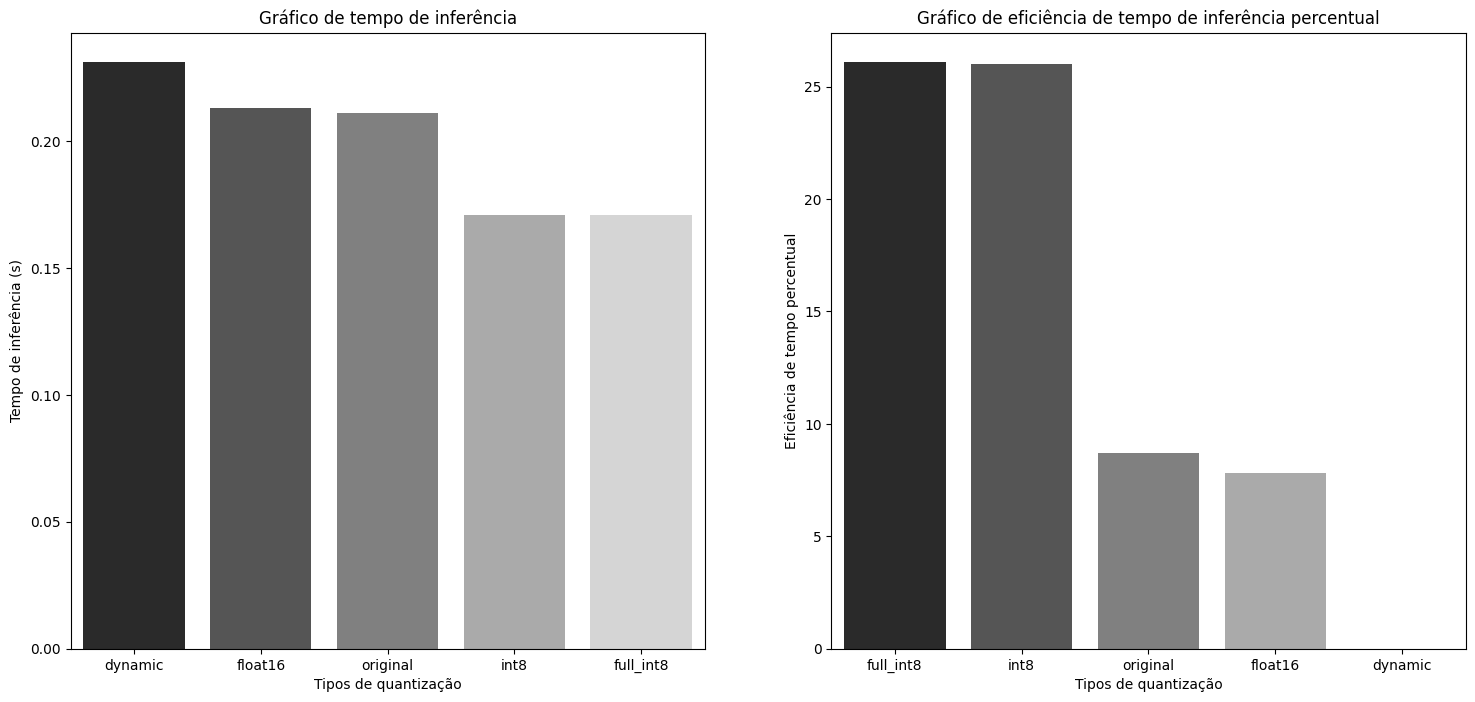

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

g1 = sns.barplot(data=df_py.groupby(['modelo'], as_index=False).agg({'time':'mean'}).sort_values(by=['time'], ascending=False), x='modelo', y='time', palette='binary_r', ax=ax[0])
g1.set_xlabel('Tipos de quantização')
g1.set_ylabel('Tempo de inferência (s)')
g1.set_title('Gráfico de tempo de inferência')

# Plot 2
g2 = sns.barplot(data=df_time.sort_values(by=['time'], ascending=False), x='modelo', y='time', palette='binary_r', ax=ax[1])
g2.set_xlabel('Tipos de quantização')
g2.set_ylabel('Eficiência de tempo percentual')
g2.set_title('Gráfico de eficiência de tempo de inferência percentual')

fig.savefig(fname='figuras/diff_time.png', dpi=300);

### Tempo de inferencia C++

In [14]:
df_time_cc = round(1 - (df_cc.groupby(['modelo']).agg({'time':'mean'}) / df_cc.groupby(['modelo']).agg({'time':'mean'}).max()), 3) * 100
df_time_cc = df_time_cc.reset_index()
df_time_cc

,modelo,time
0,dynamic,23.5
1,float16,0.0
2,int8,67.5
3,original,1.1


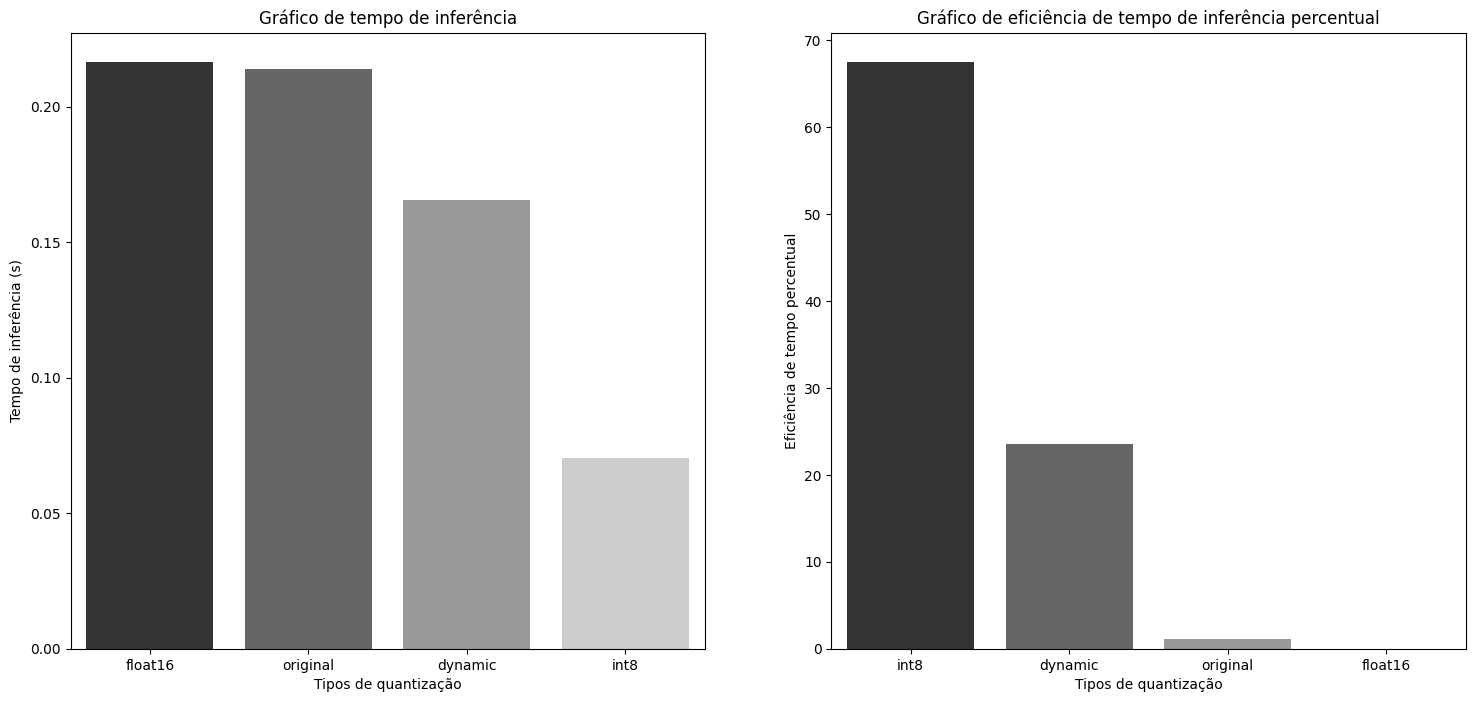

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

g1 = sns.barplot(data=df_cc.groupby(['modelo'], as_index=False).agg({'time':'mean'}).sort_values(by=['time'], ascending=False), x='modelo', y='time', palette='binary_r', ax=ax[0])
g1.set_xlabel('Tipos de quantização')
g1.set_ylabel('Tempo de inferência (s)')
g1.set_title('Gráfico de tempo de inferência')

# Plot 2
g2 = sns.barplot(data=df_time_cc.sort_values(by=['time'], ascending=False), x='modelo', y='time', palette='binary_r', ax=ax[1])
g2.set_xlabel('Tipos de quantização')
g2.set_ylabel('Eficiência de tempo percentual')
g2.set_title('Gráfico de eficiência de tempo de inferência percentual')

fig.savefig(fname='figuras/diff_time_cc.png', dpi=300);

### Comparar eficiência

In [7]:
df_all = pd.concat([df_py.loc[df_py['modelo'] != 'full_int8'], df_cc], ignore_index=True)

In [8]:
df_all

,file,modelo,time,score,model_size,language
0,KJD-0885.jpg,original,0.232882,0.792455,11497428.0,py
1,LBS-2737.jpg,original,0.209675,0.830200,11497428.0,py
2,IMG_0387.jpg,original,0.211087,0.831097,11497428.0,py
3,CYU-8900.jpg,original,0.210316,0.799787,11497428.0,py
4,JID-9361.jpg,original,0.209647,0.799481,11497428.0,py
...,...,...,...,...,...,...
395,KZD-5187.jpg,float16,0.216000,0.829752,NaN,cc
396,IMG_0467.jpg,float16,0.221000,0.712107,NaN,cc
397,IMG_0470.jpg,float16,0.216000,0.842269,NaN,cc
398,Cars406.png,float16,0.216000,0.884496,NaN,cc


Text(0, 0.5, 'Tempo de inferência (s)')

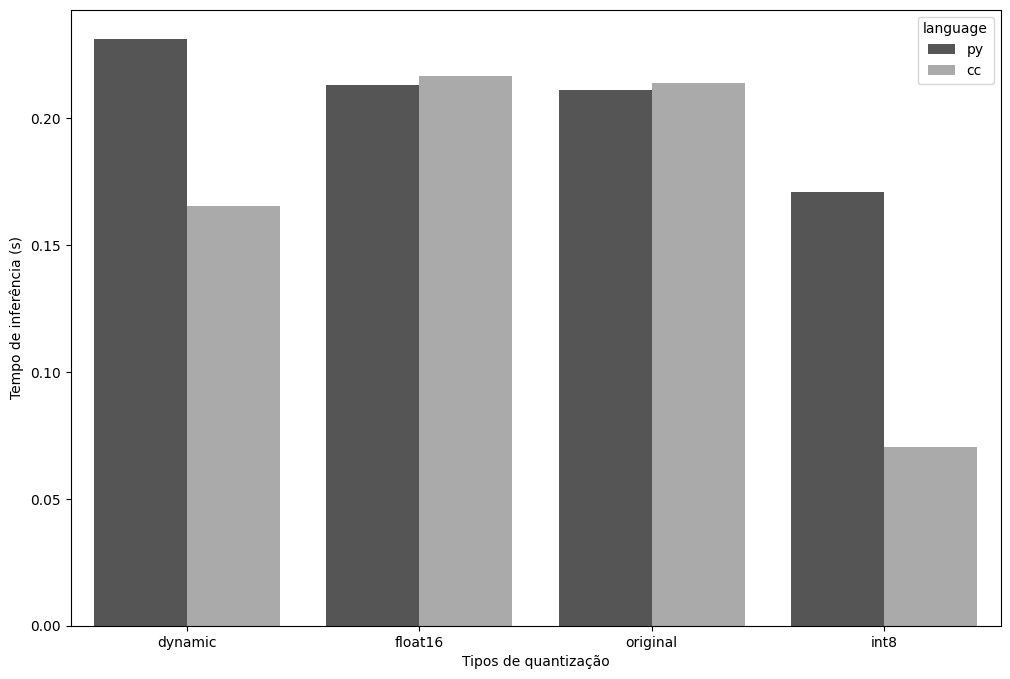

In [18]:
fig = plt.figure(figsize=(12,8))
g1 = sns.barplot(data=df_all.groupby(['modelo', 'language'], as_index=False).agg({'time':'mean'}).sort_values(by=['time'], ascending=False), x='modelo', y='time', palette='binary_r', hue='language')
g1.set_xlabel('Tipos de quantização')
g1.set_ylabel('Tempo de inferência (s)')
# g1.set_title('Gráfico comparativo do tempo de inferência entre Python e C++')
# fig.savefig(fname='figuras/comparativo.png', dpi=300);

### Score Python

<AxesSubplot:xlabel='score', ylabel='Count'>

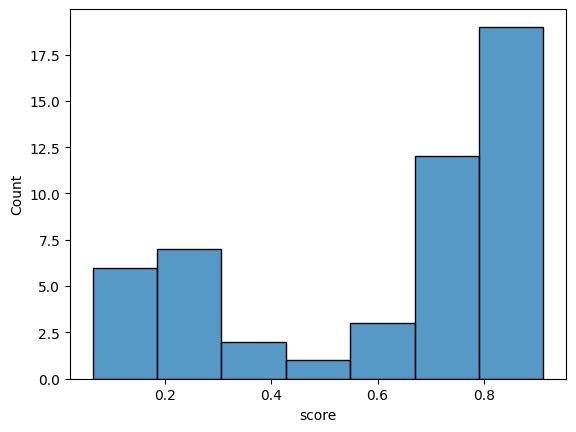

In [33]:
sns.histplot(df_py.loc[df_py['modelo'] == 'original', 'score'])

<AxesSubplot:xlabel='score', ylabel='Count'>

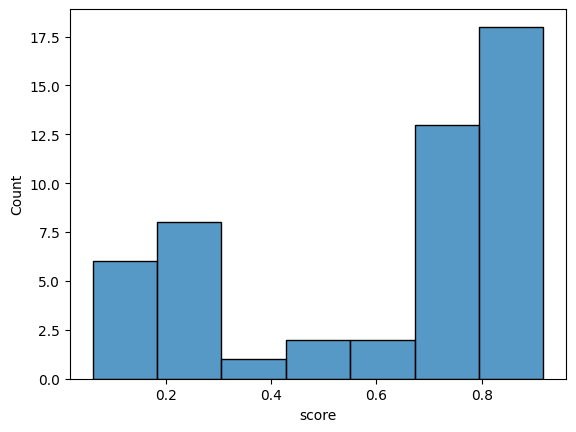

In [35]:
sns.histplot(df_py.loc[df_py['modelo'] == 'dynamic', 'score'])

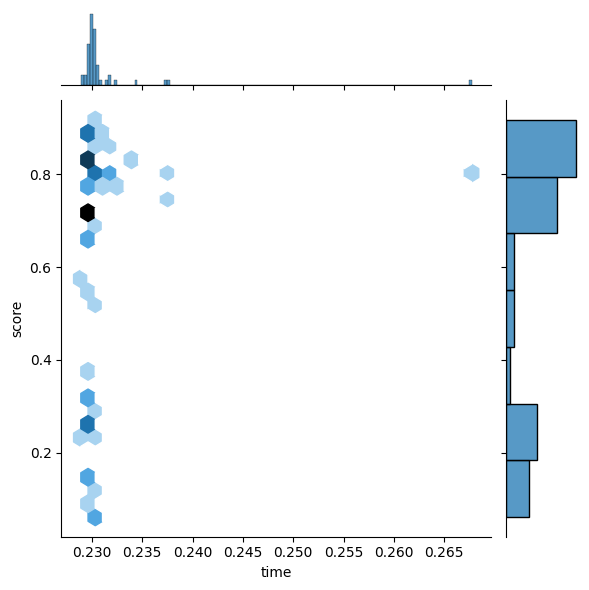

In [38]:
sns.jointplot(data=df_py.loc[df_py['modelo'] == 'dynamic', ['score', 'time']], x='time', y='score', kind='hex')

In [39]:
df_all

,file,modelo,time,score,model_size,language,size,perc_size
0,KJD-0885.jpg,original,0.232882,0.792455,11497428.0,py,11.5,100.0
1,LBS-2737.jpg,original,0.209675,0.830200,11497428.0,py,11.5,100.0
2,IMG_0387.jpg,original,0.211087,0.831097,11497428.0,py,11.5,100.0
3,CYU-8900.jpg,original,0.210316,0.799787,11497428.0,py,11.5,100.0
4,JID-9361.jpg,original,0.209647,0.799481,11497428.0,py,11.5,100.0
...,...,...,...,...,...,...,...,...
395,KZD-5187.jpg,float16,0.216000,0.829752,NaN,cc,NaN,NaN
396,IMG_0467.jpg,float16,0.221000,0.712107,NaN,cc,NaN,NaN
397,IMG_0470.jpg,float16,0.216000,0.842269,NaN,cc,NaN,NaN
398,Cars406.png,float16,0.216000,0.884496,NaN,cc,NaN,NaN


In [ ]:
plt.figure(figsize=(12,8))
g1 = sns.barplot(data=df_all.groupby(['modelo', 'language'], as_index=False).agg({'score':'mean'}).sort_values(by=['time'], ascending=False), x='modelo', y='score', palette='binary_r', hue='language')
g1.set_xlabel('Tipos de quantização')
g1.set_ylabel('Tempo de inferência (s)')
g1.set_title('Gráfico comparativo do tempo de inferência entre Python e C++');
# fig.savefig(fname='figuras/comparativo.png', dpi=300);

In [44]:
df_cc.groupby(['modelo']).agg({'score':'median'})

,score
modelo,
dynamic,0.723799
float16,0.722425
int8,0.074219
original,0.722786
